In [1]:
from optimal_transport import compute_optimal_transport, OptimalTransport

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

%matplotlib inline

## The dessert problem

In [2]:
from desserts import preferences, portions_per_person,quantities_of_dessert

Take a look at the preferences for desserts in the [KERMIT](kermit.ugent.be) research unit.

In [3]:
preferences

,merveilleux,eclair,chocolate mousse,bavarois,carrot cake
Bernard,2.0,2,1,0,0
Jan,0.0,-2,-2,-2,2
Willem,1.0,2,2,2,-1
Hilde,2.0,1,0,1,-1
Steffie,0.5,2,2,1,0
Marlies,0.0,1,1,1,-1
Tim,-2.0,2,2,1,1
Wouter,2.0,1,2,1,-1


In [4]:
M = - preferences.values  # cost is negative preferences

How many portions per person.

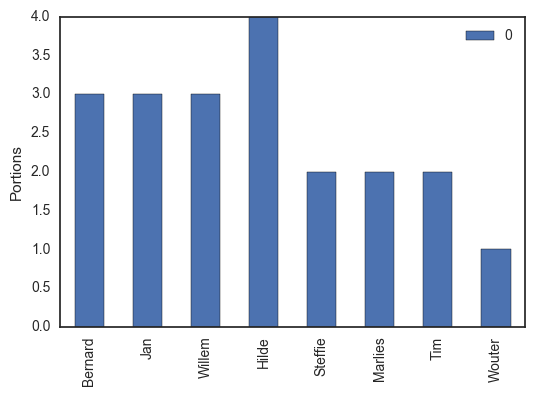

In [5]:
ax = portions_per_person.plot(kind='bar')
ax.set_ylabel('Portions')
r = portions_per_person.values.ravel()  # store as vector

How much of every dessert.

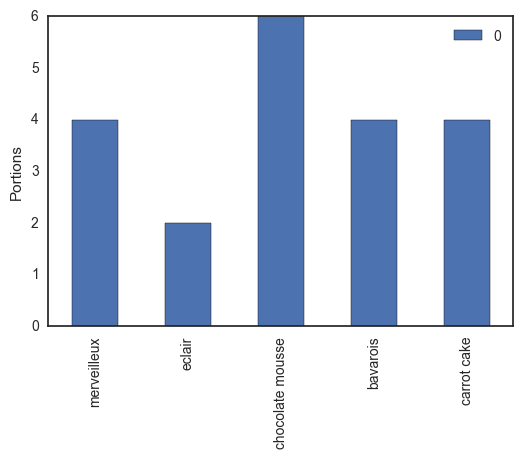

In [6]:
ax = quantities_of_dessert.plot(kind='bar')
ax.set_ylabel('Portions')
c = quantities_of_dessert.values.ravel()  # store as vector

Compute optimal transport (low entropic regularization).

Sinkhorn distance: -35.99503084811552


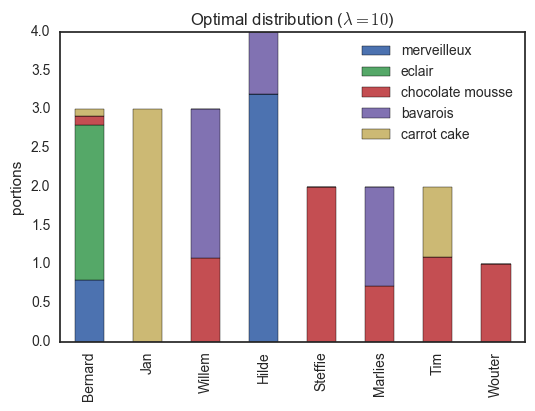

In [7]:
lam = 10

P, d = compute_optimal_transport(M,
        r,
        c, lam=lam)

partition = pd.DataFrame(P, index=preferences.index, columns=preferences.columns)
ax = partition.plot(kind='bar', stacked=True)
print('Sinkhorn distance: {}'.format(d))
ax.set_ylabel('portions')
ax.set_title('Optimal distribution ($\lambda={}$)'.format(lam))

Sinkhorn distance: -29.626510743466827


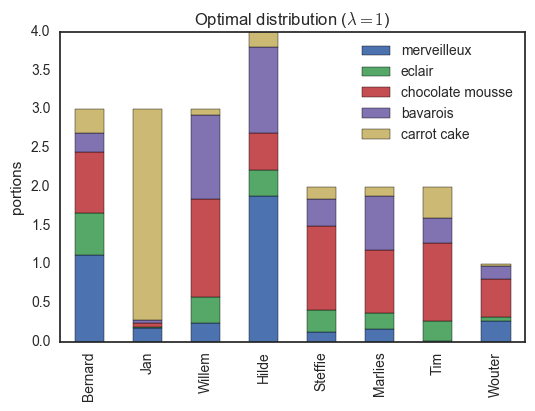

In [8]:
lam = 1

P, d = compute_optimal_transport(M,
        r,
        c, lam=lam)

partition = pd.DataFrame(P, index=preferences.index, columns=preferences.columns)
ax = partition.plot(kind='bar', stacked=True)
print('Sinkhorn distance: {}'.format(d))
ax.set_ylabel('portions')
ax.set_title('Optimal distribution ($\lambda={}$)'.format(lam))

## Matching distributions: circles

In [9]:
from sklearn.datasets import make_circles

# two concentric circles
X, y = make_circles(n_samples=500, noise=0.05,
                    factor=0.5, shuffle=False)
X1 = X[y==0]
X2 = X[y==1]

n, m = len(X1), len(X2)

In [10]:
ot2d = OptimalTransport(X1, X2, lam=100)

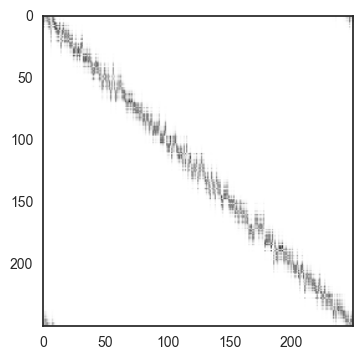

In [11]:
plt.imshow(ot2d.P)

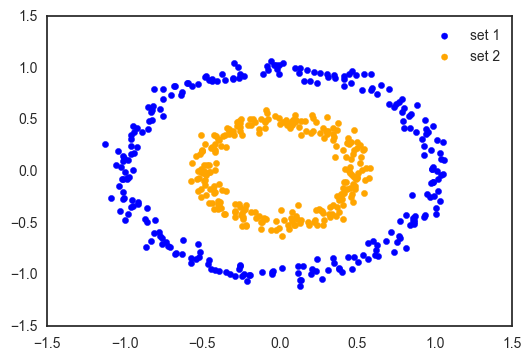

In [12]:
fig, ax = plt.subplots()

ax.scatter(X1[:,0], X1[:,1], color='blue', label='set 1')
ax.scatter(X2[:,0], X2[:,1], color='orange', label='set 2')

ax.legend(loc=0)

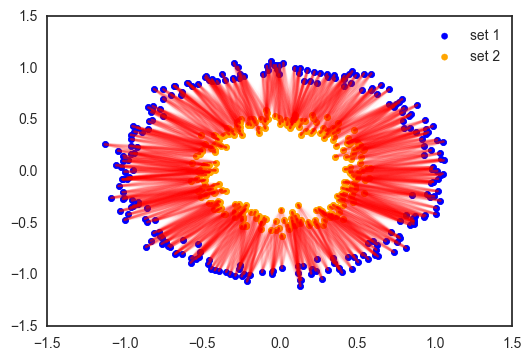

In [13]:
fig, ax = plt.subplots()

ax.scatter(X1[:,0], X1[:,1], color='blue')
ax.scatter(X2[:,0], X2[:,1], color='orange')
ax.scatter(X1[:,0], X1[:,1], color='blue', label='set 1')
ax.scatter(X2[:,0], X2[:,1], color='orange', label='set 2')

ax.legend(loc=0)

for i in range(n):
    for j in range(m):
        if ot2d.P[i,j] > 1e-5:
            ax.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], alpha=ot2d.P[i,j] * n, color='red')
    

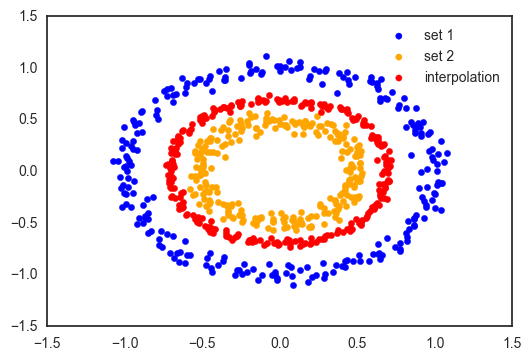

In [14]:
X, w = ot2d.interpolate(0.6)
fig, ax = plt.subplots()

ax.scatter(X1[:,0], X1[:,1], color='blue', label='set 1')
ax.scatter(X2[:,0], X2[:,1], color='orange', label='set 2')

ax.scatter(X[:,0], X[:,1], color='red', label='interpolation')
ax.legend(loc=0)

## Domain transfer

We make a small classification problem and divide in train and test. The test set is perturbated (shift + noise)

In [20]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


Xtr, Xte, ytr, yte = train_test_split(*make_blobs(n_samples=200, cluster_std=1.5), test_size=0.5)

Xte += np.random.randn(*Xte.shape) * 2 + np.array([[2, -3]]) 

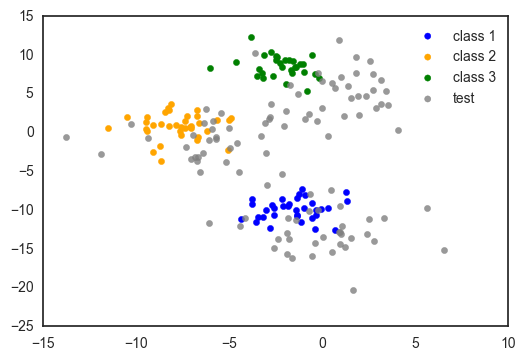

In [21]:
fig, ax = plt.subplots()

for cl, col in zip(range(3), ['blue','orange', 'green']):
    X = Xtr[ytr==cl,:]
    ax.scatter(X[:,0], X[:,1], color=col, label='class {}'.format(cl+1))
    
ax.scatter(Xte[:,0], Xte[:,1], color='gray', alpha=0.8, label='test') 

ax.legend(loc=0)

In [22]:
ot_dom_adap = OptimalTransport(Xtr, Xte, lam=50)

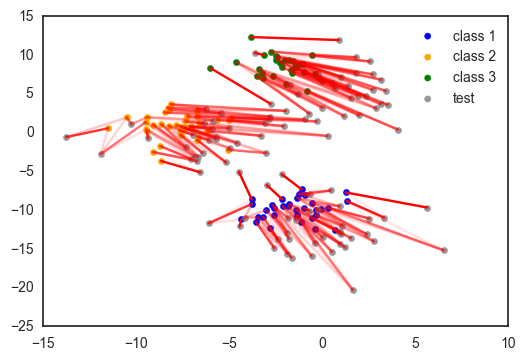

In [23]:
fig, ax = plt.subplots()



for i in range(100):
    for j in range(100):
        if ot_dom_adap.P[i,j] > 1e-4:
            ax.plot([Xtr[i,0], Xte[j,0]], [Xtr[i,1], Xte[j,1]], color='red', alpha=ot_dom_adap.P[i,j]*100)
            
for cl, col in zip(range(3), ['blue','orange', 'green']):
    X = Xtr[ytr==cl,:]
    ax.scatter(X[:,0], X[:,1], color=col, label='class {}'.format(cl+1))
    
ax.scatter(Xte[:,0], Xte[:,1], color='gray', alpha=0.8, label='test')
            
ax.legend(loc=0)

## Color transfer

See `color_transfer.py` module!

Image from:

![Princess Caroline](Figures/PC.jpg)

Image to:

![Mr. Peanutbutter](Figures/PB.jpg)

In [19]:
!python color_transfer.py --f Figures/PB.jpg --t Figures/PC.jpg -o Figures/PB2PC.jpg -metric 'mahalanobis' -lam 10 -save_color_distribution 1

/Users/michielstock/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


![Color distributions](color_distributions.png)

Result:

![Colors of mr. Peanutbutter to Princess caroline.](Figures/PB2PC.jpg)

## References

Lévy, B. and Schwindt, E. (2017). *Notions of optimal transport theory and how to implement them on a computer* [arxiv](https://arxiv.org/pdf/1710.02634.pdf)

Courty, N., Flamary, R., Tuia, D. and Rakotomamonjy, A. (2016). *Optimal transport for domain adaptation*

Cuturi, M. (2013) *Sinkhorn distances: lightspeed computation of optimal transportation distances*
